In [3]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

In [4]:
path = '../data/SMILEs'
negative_paths = glob.glob(path + '/negatives/negatives7/*.jpg')
print('loaded', len(list(negative_paths)), 'negative examples')
positive_paths = glob.glob(path + '/positives/positives7/*.jpg')
print('loaded', len(list(positive_paths)), 'positive examples')
examples = [(path, 0) for path in negative_paths] + [(path, 1) for path in positive_paths]

loaded 9475 negative examples
loaded 3690 positive examples


In [5]:
def examples_to_dataset(examples):
    X = []
    y = []
    for path, label in examples:
        img = cv.imread(path, 0)
        X.append(img)
        y.append(label)
    return np.array(X), np.array(y)

In [6]:
X, y = examples_to_dataset(examples)
X = X.astype(np.float32) / 255.
y = y.astype(np.int32)
print(X.dtype, X.min(), X.max(), X.shape)
print(y.dtype, y.min(), y.max(), y.shape)


float32 0.0 1.0 (13165, 64, 64)
int32 0 1 (13165,)


In [7]:
X = np.expand_dims(X, axis=-1)
np.save('X.npy', X)
np.save('y.npy', y)

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, model_from_json
from tensorflow.keras.layers import Dense, Input, Dropout, Activation, Conv2D, MaxPooling2D, Flatten, Conv1D
from tensorflow.keras import layers, losses

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
list(map(lambda g: tf.config.experimental.set_memory_growth(g, True), gpus));

In [9]:
# load the data
X = np.load('X.npy')
y = np.load('y.npy')

# convert classes to vector
y = np.eye(2)[y].astype(np.float32)

# shuffle all the data
indices = np.arange(len(X))
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# prepare weighting for classes since they're unbalanced
class_totals = y.sum(axis=0)
class_weight = class_totals.max() / class_totals

print(X.dtype, X.min(), X.max(), X.shape)
print(y.dtype, y.min(), y.max(), y.shape)

float32 0.0 1.0 (13165, 64, 64, 1)
float32 0.0 1.0 (13165, 2)


In [10]:
def build_model():
    model = Sequential([
        Conv2D(16, 5, activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        Conv2D(32, 5, activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [11]:
validation_split = 0.2
model = build_model()
history = model.fit(X, y, batch_size=64, class_weight=class_weight, epochs=10, verbose=1, validation_split=validation_split)

W0725 19:02:44.386343 140500007024384 deprecation.py:323] From /home/Marvelous_Coder/Documents/jupyter_files/hackaserpro/venv/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 10532 samples, validate on 2633 samples
Epoch 1/10
10532/10532 [==============================] - 2s 185us/sample - loss: 0.5025 - accuracy: 0.7513 - val_loss: 0.3709 - val_accuracy: 0.8458
Epoch 2/10
10532/10532 [==============================] - 1s 95us/sample - loss: 0.3531 - accuracy: 0.8512 - val_loss: 0.3243 - val_accuracy: 0.8625
Epoch 3/10
10532/10532 [==============================] - 1s 116us/sample - loss: 0.3028 - accuracy: 0.8798 - val_loss: 0.2786 - val_accuracy: 0.8872
Epoch 4/10
10532/10532 [==============================] - 1s 96us/sample - loss: 0.2780 - accuracy: 0.8941 - val_loss: 0.2483 - val_accuracy: 0.9032
Epoch 5/10
10532/10532 [==============================] - 1s 97us/sample - loss: 0.2525 - accuracy: 0.9053 - val_loss: 0.2379 - val_accuracy: 0.9096
Epoch 6/10
10532/10532 [==============================] - 1s 83us/sample - loss: 0.2437 - accuracy: 0.9108 - val_loss: 0.2315 - val_accuracy: 0.9126
Epoch 7/10
10532/10532 [==============================]

In [12]:
with open('model.json', 'w') as f:
    f.write(model.to_json())
    
model.save_weights('weights.h5')

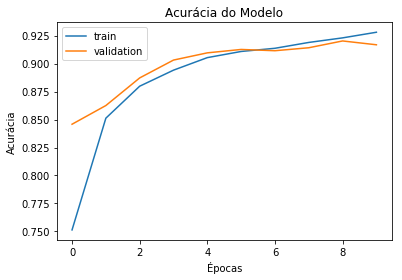

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia do Modelo')
plt.ylabel('Acurácia')
plt.xlabel('Épocas')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

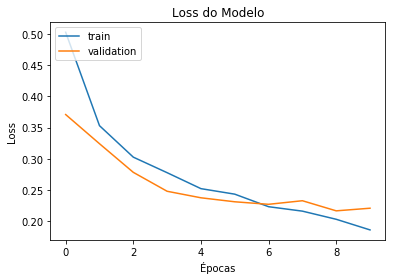

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss do Modelo')
plt.ylabel('Loss')
plt.xlabel('Épocas')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [15]:
model = model_from_json(open('model.json').read())
model.load_weights('weights.h5')

In [16]:
X = np.load('X.npy')
model(X)

<tf.Tensor: id=15586, shape=(13165, 2), dtype=float32, numpy=
array([[9.9985647e-01, 1.4354922e-04],
       [9.9603748e-01, 3.9625149e-03],
       [8.7645870e-01, 1.2354129e-01],
       ...,
       [7.4330591e-02, 9.2566943e-01],
       [1.5676206e-01, 8.4323794e-01],
       [1.4838979e-01, 8.5161024e-01]], dtype=float32)>